In [1]:
import pickle,sys
import random
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [2]:

r=6371
per_lon=r/360*2*3.14159*np.cos(np.pi/6)
per_lat=r/360*2*3.14159
per_lonlat=np.array([per_lon,per_lat])

def cal_dis(array1,array2):
    return np.sqrt(np.sum((np.abs(array1-array2)*per_lonlat)**2))

## 网格划分

In [3]:
# load and process map grid
map_data=np.loadtxt("hexagon_grid_table.csv",dtype=str)

map_xy=[]
map_id=[]
for i,grid in enumerate(map_data):
    if i!=4183:
        grid=grid.split(',')
        map_id.append(grid[0])
        map_xy.append(np.reshape(np.array(grid[1:],dtype=float),[6,2])[None,:,:])
map_xy=np.concatenate(map_xy,axis=0)
grid_mean=np.mean(map_xy,axis=1)
assert grid_mean.shape==(8518,2)

In [4]:
# partitions process 8518 grids into 121 grids 
# in the way of matrix
corner=[
    [103.9521,30.7900],
    [103.9521,30.5400],
    [104.1934,30.7900],
    [104.1934,30.5400]
]
corner=np.array(corner)
radius=cal_dis(corner[0],corner[1])/11
lat_num=int(cal_dis(corner[0],corner[1])/radius)
lon_num=int(round(cal_dis(corner[0],corner[2])/(radius*np.sqrt(3)/2)))
lat_per_radius=(corner[0,1]-corner[1,1])/lat_num
lon_per_radius=(corner[2,0]-corner[0,0])/lon_num
print(radius, lat_num, lon_num, lat_per_radius, lon_per_radius)
#assert lat_num==10 and lon_num==13 , print(lat_num,lon_num)
grid_small=np.zeros((lat_num,lon_num,2))
for i in range(lat_num):
    for j in range(lon_num):
        grid_small[i,j][0]=lon_per_radius*j+corner[0,0]
        if j%2==0:
            grid_small[i,j][1]=-lat_per_radius*(i+0.5)+corner[0,1]
        else:
            grid_small[i,j][1]=-lat_per_radius*i+corner[0,1]


2.527155289141414 11 11 0.022727272727272728 0.02193636363636322


In [102]:
import folium
draw_map=folium.Map(location=[31,104],zoom_start=15,control_scale=True,tiles='OpenStreetMap')
for i in range(lat_num):
    for j in range(lon_num):
        folium.CircleMarker(list(grid_small[i,j][[1,0]]),radius=1,color='blue',popup=folium.Popup(str(i*lon_num+j))).add_to(draw_map)
#draw_map.save('map_130.html')
with open('processed/map_121.pkl', 'wb') as handle:
    pickle.dump(grid_small, handle, protocol=pickle.HIGHEST_PROTOCOL)
draw_map

In [6]:
## 读取保存的网格

with open('processed/map_121.pkl', 'rb') as handle:
    grid_mean = pickle.load(handle) 
print(grid_mean.shape)
M,N,_ = grid_mean.shape


(11, 11, 2)


In [8]:
grid_mean

array([[[103.9521    ,  30.77863636],
        [103.97403636,  30.79      ],
        [103.99597273,  30.77863636],
        [104.01790909,  30.79      ],
        [104.03984545,  30.77863636],
        [104.06178182,  30.79      ],
        [104.08371818,  30.77863636],
        [104.10565455,  30.79      ],
        [104.12759091,  30.77863636],
        [104.14952727,  30.79      ],
        [104.17146364,  30.77863636]],

       [[103.9521    ,  30.75590909],
        [103.97403636,  30.76727273],
        [103.99597273,  30.75590909],
        [104.01790909,  30.76727273],
        [104.03984545,  30.75590909],
        [104.06178182,  30.76727273],
        [104.08371818,  30.75590909],
        [104.10565455,  30.76727273],
        [104.12759091,  30.75590909],
        [104.14952727,  30.76727273],
        [104.17146364,  30.75590909]],

       [[103.9521    ,  30.73318182],
        [103.97403636,  30.74454545],
        [103.99597273,  30.73318182],
        [104.01790909,  30.74454545],
        

## 订单处理

In [9]:
r=6371
per_lon=r/360*2*3.14159*np.cos(np.pi/6)
per_lat=r/360*2*3.14159
per_lonlat=np.array([per_lon,per_lat])

def cal_dis(array1,array2):
    return np.sqrt(np.sum((np.abs(array1-array2)*per_lonlat)**2,axis=-1))

In [10]:
## 读取保存的网格

with open('processed/map_121.pkl', 'rb') as handle:
    grid_mean = pickle.load(handle) 
print(grid_mean.shape)
M,N,_ = grid_mean.shape
grid_mean = grid_mean.reshape((-1,2))

# use kdtree get neighbor
from scipy.spatial import KDTree
kdtree=KDTree(list(grid_mean*per_lonlat))
# test
dis,i=kdtree.query(grid_mean[5]*per_lonlat)
#assert i==5

(11, 11, 2)


In [11]:
# 处理订单，并保存为完整订单
day=1
with open('total_ride_request/order_201611'+format(day,'0>2'), 'r') as f:
    data=f.readlines()

order_commute_dist = np.zeros((len(grid_mean), len(grid_mean),144), dtype=np.int32)
#dis_list = np.zeros(len(data), dtype=np.float32)
price_list = np.zeros(len(data), dtype=np.float32)
start_t_list = np.zeros(len(data), dtype=np.int32)
dura_list = np.zeros(len(data), dtype=np.int32)
flag_list = np.zeros(len(data),dtype=np.bool)
start_grid_list = np.zeros(len(data), dtype=np.int32)
end_grid_list = np.zeros(len(data), dtype=np.int32)
for i,row in enumerate(data):
    # '39d471630d26439111a7746d164d34eb,1478091677,1478092890,104.00816,30.70622,104.064147,30.685848,3.82\n'
    row=row.split(',')
    dis_start,id_start=kdtree.query(np.array([float(row[3]),float(row[4])])*per_lonlat)
    dis_end,id_end=kdtree.query(np.array([float(row[5]),float(row[6])])*per_lonlat)
    if dis_start<=1.3 and dis_end<=1.3:
        start_grid = id_start
        end_grid = id_end
        start_time = int(row[1])
        end_time = int(row[2])
        price = float(row[7])
        t=time.localtime(start_time)
        start_t = (t.tm_hour*60+t.tm_min)
        t=time.localtime(end_time)
        end_t = (t.tm_hour*60+t.tm_min)
        order_commute_dist[start_grid, end_grid, start_t//10]+=1
        price_list[i]=price
        start_t_list[i] = start_t
        dura_list[i]=-start_t+end_t
        start_grid_list[i]=start_grid
        end_grid_list[i]=end_grid
        flag_list[i]=True
start_grid = grid_mean[start_grid_list[flag_list]]
end_grid = grid_mean[end_grid_list[flag_list]]
dis_list = cal_dis(start_grid, end_grid)

process_data={
    'start grid':start_grid_list[flag_list],
    'end grid':end_grid_list[flag_list],
    'price':price_list[flag_list],
    'start time':start_t_list[flag_list],
    'duration':dura_list[flag_list],
    'distance':dis_list,
    'order commute':order_commute_dist
}
with open('processed/order1_grid121.pkl', 'wb') as handle:
    pickle.dump(process_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [108]:
## 读取处理后的订单
with open('processed/order1_grid121.pkl', 'rb') as handle:
    data = pickle.load(handle) 

for k,v in data.items():
    print(k,v.shape)

start grid (184106,)
end grid (184106,)
price (184106,)
start time (184106,)
duration (184106,)
distance (184106,)
order commute (121, 121, 144)


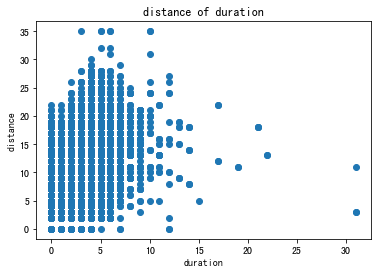

In [4]:
# 可视化
def stem(x,y,xlabel,ylabel,save_name):
    plt.figure(save_name)
    plt.scatter(x,y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend(loc='upper right')
    plt.title(ylabel+' of '+xlabel)

price = data['price']
duration = data['duration']//10
duration[duration<0]= 144+duration[duration<0]
distance = np.round(data['distance']).astype(np.int32)



stem(duration, distance, 'duration', 'distance', 'duration-distance'  )

In [5]:
def leastsq(x,y):
    x= np.concatenate([x,np.ones((x.shape[0],1))],axis=-1)
    w = np.linalg.inv(np.matmul(x.T, x))
    w= np.matmul(w, x.T)
    w=np.matmul(w,y)
    error = np.mean(np.sum((y-np.matmul(x,w))**2, axis=-1))
    print(error)
    return w
leastsq(duration[:,None], distance[:,None])

9.015960832754834


array([[2.23580907],
       [2.56917904]])

In [95]:
duration[duration<0]= 144+duration[duration<0]

In [111]:
# 验证 距离和时间的关系
duration = np.round(data['duration']/10).astype(np.int32)
duration[duration<0]= 144+duration[duration<0]
distance = np.round(data['distance']).astype(np.int32)
dura_num = np.zeros(20)
dura_dis = np.zeros(20)
for i in range(len(duration)):
    dura = duration[i]
    if dura>=19:
        dura=19
    dura_num[dura]+=1
    dura_dis[dura]+=distance[i]
dura_mean = dura_dis/(dura_num+1e-5)
dura_mean#

array([ 1.91411713,  3.10463632,  6.02218995,  8.74443754, 10.45416541,
       11.60991204, 12.4268727 , 13.15821474, 13.6078426 , 13.90163707,
       13.52499662, 15.43749035, 15.53844959,  9.99998889, 10.999978  ,
       14.999925  ,  6.99993   , 10.999945  ,  0.        , 12.66665259])

In [17]:
# 验证 价格和时间的关系
duration = np.round(data['duration']/10).astype(np.int32)
duration[duration<0]= 144+duration[duration<0]
price = data['price']
dura_num = np.zeros(20)
dura_price = np.zeros(20)
dura_dist={}
for i in range(len(duration)):
    dura = duration[i]
    if dura>=19:
        dura=19
    dura_num[dura]+=1
    dura_price[dura]+=price[i]
    if dura not in dura_dist.keys():
        dura_dist[dura]=[price[i]]
    else:
        dura_dist[dura].append(price[i])
dura_mean = dura_price/(dura_num+1e-5)
print(dura_mean)
dura_std = np.zeros(20)
for k in dura_dist.keys():
    dura_std[k]= np.array(dura_dist[k]).std()
print(dura_std)

[ 1.84297032  2.23573282  3.67035554  5.49099318  6.98509504  8.31860098
  9.35560117 10.18884842 10.80031812 11.62151752 12.82721978 14.61226608
 18.58763634 20.49767608 21.04553205 13.00993518 21.26978776 28.8499273
  0.         30.49896938]
[ 0.13517419  0.63724232  1.39200628  1.96423233  2.40295291  2.72169709
  3.03340125  2.85474992  2.80858111  2.30170274  4.66523027  3.02463937
  3.74364042 10.25141811  2.96182799  0.          0.          0.28999996
  0.         13.55869007]


In [42]:
order_time = np.sum(data['order commute'], axis=1)

In [44]:
order_time.shape

(156, 144)

In [68]:
np.where(np.sum(order_time,axis=1)>10000)

(array([84, 85, 86, 98]),)

In [81]:
np.sum(data['order commute'],axis=2)[85][85]

521

In [92]:
np.sum(order_time,axis=1).reshape((11,11))

ValueError: cannot reshape array of size 156 into shape (11,11)

In [110]:
np.sum(np.sum(data['order commute'],axis=0), axis=1).reshape((11,11))

array([[  154,    26,    11,    22,    36,    47,    41,     3,   165,
          206,    67],
       [   72,   204,   291,   307,   994,  2197,   539,   134,   194,
           63,    20],
       [   81,   263,   220,   391,   835,   459,   100,   512,   152,
          563,    17],
       [   14,   292,   909,   876,  6004,  3303,  3485,  2607,   694,
          134,   614],
       [  222,   238,   740,  2807,  8348,  6705, 11549,  4784,  1326,
          351,   907],
       [  287,   929,  1524,  2391,  7359, 11645, 18426, 11829,  3679,
         1160,   241],
       [   80,   314,   991,  1919,  3008, 12769,  6892,  7105,  1895,
          625,   202],
       [   30,   267,   388,  1160,  1138,  3021,  1798,  2131,   778,
         2354,   225],
       [   73,   177,   167,   122,   344,  1385,   702,   900,   483,
          464,    33],
       [ 1231,    71,   340,   107,   135,   719,    18,   210,    37,
          207,    51],
       [    4,   142,    75,   125,   256,   291,   309,    

In [54]:
np.sum(data['order commute'], axis=0)[100]

array([ 7, 13, 23, 17, 17, 11, 11, 12, 11,  9,  7, 16,  8,  4,  2,  8,  5,
       10,  2,  2,  2,  1,  6,  4,  1,  3,  4,  3,  1,  0,  3,  0,  0,  1,
        1,  0,  1,  1,  5,  4,  0,  6,  6, 25, 14, 18, 17, 15, 18, 17, 21,
       19, 18, 31, 21, 25, 23, 29, 37, 32, 16, 25, 30, 21, 30, 36, 27, 24,
       21, 31, 28, 46, 26, 22, 30, 25, 32, 40, 23, 24, 32, 30, 43, 44, 34,
       30, 30, 30, 41, 41, 25, 26, 25, 28, 45, 43, 27, 40, 29, 25, 35, 52,
       35, 40, 45, 58, 53, 55, 38, 44, 36, 52, 59, 62, 35, 34, 42, 56, 52,
       66, 29, 39, 37, 26, 31, 48, 37, 47, 35, 22, 39, 56, 33, 31, 26, 21,
       31, 42, 27, 26, 21, 21, 18, 17])

In [70]:
data['order commute'][98,:,100]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  6,  0,  2,  0,  0,  0,
        0,  0,  0,  0,  1,  2,  3,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0,
        1,  3,  5,  9,  8, 12,  0,  5,  0,  0,  0,  2,  1,  7,  3, 15, 24,
       13, 18,  7,  1,  0,  0,  0,  0,  0,  0,  3,  5,  7, 17,  1,  8,  0,
        1,  1,  0,  0,  2,  1,  1,  5,  5,  6,  8,  1,  2,  1,  0,  0,  0,
        0,  0,  0,  0,  1,  3,  2,  3,  2,  0,  0,  0,  4,  1,  0,  2,  2,
        2,  2,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,  1,  1,  0,  0,
        0,  0,  0], dtype=int32)

In [91]:
np.sum(order_time)

190794

In [26]:
## 读取处理后的订单

def process_dura(data):
    duration = np.round(data['duration']/10).astype(np.int32)
    duration[duration<0]= 144+duration[duration<0]
    distance = np.round(data['distance']).astype(np.int32)
    dura_num = np.zeros(20)
    dura_dis = np.zeros(20)
    for i in range(len(duration)):
        dura = duration[i]
        if dura>=19:
            dura=19
        dura_num[dura]+=1
        dura_dis[dura]+=distance[i]
    dura_mean = dura_dis/(dura_num+1e-5)
    return dura_mean

def process_price(data):
    duration = np.round(data['duration']/10).astype(np.int32)
    duration[duration<0]= 144+duration[duration<0]
    price = data['price']
    dura_num = np.zeros(20)
    dura_price = np.zeros(20)
    dura_dist={}
    for i in range(len(duration)):
        dura = duration[i]
        if dura>=19:
            dura=19
        dura_num[dura]+=1
        dura_price[dura]+=price[i]
        if dura not in dura_dist.keys():
            dura_dist[dura]=[price[i]]
        else:
            dura_dist[dura].append(price[i])
    dura_mean = dura_price/(dura_num+1e-5)
    dura_std = np.zeros(20)
    for k in dura_dist.keys():
        dura_std[k]= np.array(dura_dist[k]).std()
    return np.stack([dura_mean, dura_std], axis=1)

def process_neighbor():
    # 处理邻居的OD订单
    neighbor_dis = np.zeros((11*11,11*11),dtype=np.int32)
    neighbor_dis[:,:] = 100
    for id in range(11*11):
        neighbor_dis[id, id]=0
        i,j = ids_1dto2d(id, 11,11)
        layers_neighbor = get_layers_neighbors(i,j,8,11,11)
        for dis,layer in enumerate(layers_neighbor):
            for item in layer:     
                neighbor_dis[id, ids_2dto1d(item[0],item[1],11,11) ]=dis+1
    return neighbor_dis

neighbor_dis = process_neighbor()
dura_mean = np.zeros(20)
price_para = np.zeros((20,2))
order_param = np.zeros((121, 121,144), dtype=np.int32)
for day in range(1,2):
    with open('processed/order_grid121/{}.pkl'.format(day), 'rb') as handle:
        data = pickle.load(handle) 
    dura_mean+=process_dura(data)
    price_para += process_price(data)
    order_param += data['order commute']
order_param[neighbor_dis>=100]=0

dataset={
    'duration':dura_mean,
    'price':price_para,
    'neighbor':neighbor_dis,
    'order':order_param
}
with open('processed/data_day1_grid121.pkl', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('processed/data_day1_grid121.pkl', 'rb') as handle:
        data = pickle.load(handle) 

In [34]:
data.keys()
order=data['order']
price = data['price']

In [37]:
price[:,1]/=2

In [38]:
price

array([[ 1.8423339 ,  0.06737357],
       [ 2.23449898,  0.31893536],
       [ 3.65923586,  0.68968594],
       [ 5.41410821,  0.95446748],
       [ 6.79024559,  1.1304661 ],
       [ 7.89824673,  1.23741055],
       [ 8.78994644,  1.32625365],
       [ 9.72681522,  1.35024381],
       [10.37545056,  1.36804819],
       [11.45475219,  1.1599313 ],
       [11.56099705,  1.57212472],
       [13.54311648,  1.3915478 ],
       [18.30306303,  1.96015739],
       [13.24665192,  3.15421152],
       [22.29795536,  1.24434078],
       [13.00993518,  0.        ],
       [13.90986075,  0.        ],
       [29.13985369,  0.        ],
       [ 0.        ,  0.        ],
       [32.37218608,  6.50336313]])

In [5]:
np.where(order.sum(-1).sum(-1)>10000)

(array([50, 60, 61, 62, 71]),)

In [21]:
new_order = order.copy()
new_order[np.logical_and(new_order<=8, new_order>0)] = 1
new_order[new_order>8] = new_order[new_order>8]/8

In [33]:
new_order[30].sum(-1)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  5,  0,  0,
        0,  0,  2,  3,  3,  3, 20,  7,  1,  2,  0,  0,  1,  1,  2,  3,  5,
       14,  0,  1,  0,  0,  0,  2,  0,  5,  3,  4,  7,  1,  4,  2,  0,  0,
        0,  1,  0,  1,  1,  4,  0,  1,  0,  0,  0,  0,  0,  0,  1,  1,  2,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [23]:
new_order.sum(-1).sum(-1)

array([ 102,   20,   12,   24,   50,   38,   35,    3,  152,  151,   37,
         60,  126,  201,  222,  770, 1242,  386,  115,  124,   45,    5,
         49,  188,  166,  295,  610,  363,   66,  355,  121,  256,   16,
         10,  252,  674,  634, 2935, 2043, 1970, 1825,  517,  199,  437,
        164,  138,  506, 1475, 3454, 3060, 4189, 2372,  878,  222,  636,
        196,  665,  962, 1277, 2993, 4320, 5610, 4148, 1906,  683,  193,
         66,  266,  651, 1068, 1228, 4503, 2610, 3055, 1053,  406,  189,
         42,  200,  283,  665,  706, 1352,  967, 1103,  554,  952,  189,
         72,  132,  146,  114,  263,  777,  459,  575,  284,  308,   24,
        348,   57,  231,   81,  122,  503,   16,  169,   22,  126,   38,
          4,   96,   51,   81,  196,  226,  198,   40,    2,   10,    3])

In [24]:
new_order.sum(0).sum(-1)

array([  99,   17,    7,   15,   27,   42,   29,    3,  139,  146,   46,
         59,  162,  248,  237,  690, 1255,  397,  112,  156,   52,   19,
         60,  217,  178,  302,  607,  361,   76,  396,  114,  386,   16,
         13,  238,  651,  600, 2777, 1849, 1860, 1645,  543,  101,  455,
        176,  184,  515, 1535, 3421, 3287, 4483, 2488,  870,  290,  628,
        228,  646,  921, 1301, 3029, 4129, 5274, 4044, 1913,  724,  196,
         64,  246,  656,  998, 1265, 4357, 2443, 2950, 1039,  446,  169,
         29,  204,  300,  700,  659, 1422,  927, 1123,  519, 1248,  176,
         56,  140,  135,  107,  259,  782,  468,  577,  351,  339,   32,
        609,   59,  248,   84,  109,  454,   15,  168,   31,  173,   44,
          1,  112,   53,   99,  198,  222,  223,   35,    1,   13,    9])

In [65]:
large_grid={i:0 for i in range(121)}

a= np.sum(revise_order_commute, axis=1)
for i in range(144):
    b = np.where(a[:,i]>=250)[0]
    for n in b:
        large_grid[n]+=1

            

In [66]:
large_grid

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0}

In [4]:
with open('processed/order_grid121/{}.pkl'.format(1), 'rb') as handle:
    data = pickle.load(handle) 
order_commute = data['order commute']

In [11]:
order_commute[neighbor_dis==100]=0
order_num = np.sum(np.sum(order_commute, axis=1), axis=1)
driver = np.log(order_num)
driver[order_num<200] = 0

In [50]:
revise_order_commute = order_commute.copy()
revise_order_commute[order_commute>=4] = revise_order_commute[order_commute>=4]/2 
np.sum(np.sum(revise_order_commute, axis=1), axis=1)

array([  131,    23,    13,    30,    58,    47,    41,     4,   186,
         184,    45,    65,   161,   250,   279,  1068,  1864,   488,
         140,   147,    50,     6,    60,   220,   191,   381,   805,
         450,    78,   442,   145,   334,    18,    12,   300,   935,
         890,  4928,  3146,  3137,  2663,   663,   280,   588,   209,
         170,   683,  2361,  6075,  4952,  7804,  3806,  1257,   275,
         882,   230,   889,  1457,  2018,  5029,  8598, 12264,  8255,
        3017,  1008,   236,    72,   316,   907,  1719,  2132,  8924,
        4867,  5456,  1630,   560,   245,    50,   259,   356,  1005,
        1059,  2306,  1524,  1775,   780,  1480,   230,    86,   160,
         173,   134,   341,  1202,   648,   822,   372,   418,    27,
         458,    68,   299,   102,   140,   737,    18,   211,    24,
         154,    47,     4,   119,    68,   105,   233,   274,   255,
          44,     2,    12,     4])

In [51]:
np.sum(np.sum(revise_order_commute, axis=0), axis=1)

array([  119,    19,     7,    19,    35,    45,    38,     3,   162,
         184,    59,    68,   188,   281,   292,   938,  1892,   508,
         132,   188,    63,    20,    78,   256,   218,   377,   796,
         445,    97,   495,   146,   531,    17,    14,   289,   885,
         829,  4689,  2837,  2948,  2377,   676,   130,   583,   213,
         226,   702,  2424,  6113,  5445,  8332,  3963,  1218,   347,
         843,   279,   878,  1354,  2064,  5398,  8070, 11712,  8072,
        3039,  1039,   230,    79,   305,   916,  1616,  2241,  8674,
        4719,  5255,  1601,   592,   198,    29,   258,   376,  1045,
        1012,  2418,  1497,  1797,   719,  1951,   214,    65,   168,
         161,   120,   336,  1190,   661,   839,   455,   442,    33,
         938,    68,   329,   102,   131,   653,    17,   197,    37,
         197,    48,     1,   134,    65,   117,   247,   279,   289,
          41,     1,    16,    11])

In [42]:
print(np.sum(np.round(order_param).astype(np.int32)))
print(np.sum(order_param_copy))

170293
117418


In [113]:
dura_mean

array([ 1.89599795,  3.07520398,  5.82092937,  8.43095659, 10.04956491,
       11.17934364, 11.98543086, 12.73460573, 13.27484378, 13.44116413,
       13.5111121 , 12.87695913, 13.38539233, 12.15054391, 10.01930018,
        9.30694168,  8.51471796,  7.07468436,  5.42329915,  7.96128102])

In [114]:
price_para

array([[ 1.85465207,  0.14699411],
       [ 2.23586085,  0.63090062],
       [ 3.57903801,  1.34638836],
       [ 5.27011663,  1.85265028],
       [ 6.59241941,  2.16875782],
       [ 7.68229975,  2.38411987],
       [ 8.56021546,  2.50683341],
       [ 9.49770607,  2.64945217],
       [10.39858041,  2.7844873 ],
       [11.44282726,  2.94994328],
       [12.53061456,  3.381452  ],
       [13.64541848,  2.97765568],
       [15.65390581,  3.57270697],
       [16.15597247,  3.56161061],
       [16.99214021,  2.9713614 ],
       [14.98102464,  1.97193529],
       [15.57598769,  1.39078595],
       [12.77922223,  1.15684352],
       [11.08866348,  0.38735745],
       [25.00496646,  8.76433196]])

In [6]:
# 处理邻居的OD订单
neighbor_dis = np.zeros((11*11,11*11),dtype=np.int32)
neighbor_dis[:,:] = 100
for id in range(11*11):
    neighbor_dis[id, id]=0
    i,j = ids_1dto2d(id, 11,11)
    layers_neighbor = get_layers_neighbors(i,j,8,11,11)
    for dis,layer in enumerate(layers_neighbor):
        for item in layer:     
            neighbor_dis[id, ids_2dto1d(item[0],item[1],11,11) ]=dis+1

In [3]:
layers_neighbor = get_layers_neighbors(5,5,9,11,11)

In [16]:
neighbor_dis[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100,   1,   1,
         2,   3,   4,   5,   6,   7,   8,   9, 100,   2,   2,   3,   3,
         4,   5,   6,   7,   8,   9, 100,   3,   3,   4,   4,   5,   5,
         6,   7,   8,   9, 100,   4,   4,   5,   5,   6,   6,   7,   7,
         8,   9, 100,   5,   5,   6,   6,   7,   7,   8,   8,   9,   9,
       100,   6,   6,   7,   7,   8,   8,   9,   9, 100, 100, 100,   7,
         7,   8,   8,   9,   9, 100, 100, 100, 100, 100,   8,   8,   9,
         9, 100, 100, 100, 100, 100, 100, 100,   9,   9, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100], dtype=int32)

In [4]:
layers_neighbor[0]

[[4, 5], [4, 6], [5, 6], [6, 5], [5, 4], [4, 4]]